# Tutorial for Calculating Partisan Dislocation

In this notebook, we will demonstrate how the `partisan_dislocation` package can be used to convert a shapefile with precinct boundaries and vote counts into a shapefile of representative voter points with associated partisan dislocation scores, introduced in [Partisan Dislocation: A Precinct-Level Measure ofRepresentation and Gerrymandering](http://www.nickeubank.com/defordeubankrodden_dislocation/) by Deford, Eubank and Rodden. 

In [1]:
# Import relevant libraries. 
# Note that `partisan_dislocation` can be 
# installed from pypi by running 
# `pip install partisan_dislocation` 
# at the command line. 

import partisan_dislocation as pdn
import geopandas as gpd

## Loading and Preparing Data

First, we'll load the shapefile of all precincts in the United States with 2008 Presidential vote counts used in Deford, Eubank and Rodden. This file can be found in [the repository](https://github.com/nickeubank/partisan_dislocation/tree/master/2008_presidential_precinct_data) for the Partian Dislocation package. Note that to download this data, you'll need to first install [git-lfs](http://www.git-lfs.github.com), then clone the respository. 

In [2]:
# The repository fop
us = gpd.read_file('2008_presidential_precinct_data/2008_presidential_precinct_counts.shp')

In [3]:
us.head()

,P2008_D,P2008_R,STATE,COUNTY,NAME,geometry
0,1891.0,768.0,48,453,Travis,"POLYGON ((1717728.210 7368333.015, 1717777.958..."
1,1101.0,798.0,48,201,Harris,"POLYGON ((1912654.744 7312563.597, 1912663.706..."
2,924.0,497.0,48,453,Travis,"POLYGON ((1714250.972 7355096.188, 1714202.932..."
3,1.0,0.0,48,029,Bexar,"POLYGON ((1669729.218 7263595.876, 1669410.636..."
4,780.0,585.0,48,029,Bexar,"POLYGON ((1629491.358 7265195.230, 1629492.219..."


This dataset is *very* large, and (due to the limitations of Python) this package is not super fast, so for practice, let's just work with data from North Carolina. 

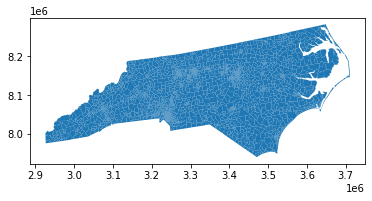

In [4]:
# Subset to North Carolina
nc = us[us.STATE == "37"]
nc.plot()

Now we'll make sure the data has been projected using an equidistant projection we like. Note that the `partisan_dislocation` package will work with the data in whatever projection you provide, so make sure you're working with a projection you're comfortable with!

In [5]:
nc = nc.to_crs('esri:102010')

In [6]:
nc.crs

<Projected CRS: ESRI:102010>
Name: North_America_Equidistant_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - Canada and USA (CONUS, Alaska mainland)
- bounds: (-172.54, 23.81, -47.74, 86.46)
Coordinate Operation:
- name: North_America_Equidistant_Conic
- method: Equidistant Conic
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Make Voter Points and Measure Nearest Neighbor Partisanship

Now that we have precinct polygons and vote counts, we need to create a GeoDataFrame of representative voter points, where the number of Democratic and Republican points in each precinct is proportional to the number of votes cast for each party. Here we'll downsample to create (in expectation) one representative voter point per 1,000 actual votes. 

In [7]:
voters = pdn.random_points_in_polygon(nc, p=0.001, 
                                      dem_vote_count="P2008_D", 
                                      repub_vote_count="P2008_R")

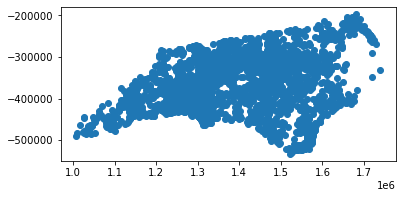

In [8]:
voters.plot()

Now that we have these representative voter points, we want to calculate the share of each voters nearest neighbors who are Democrats, which we can do with the `calculate_voter_knn` function. 

This function takes two arguments: the number of nearest neighbors to identify, and the column with the voter feature you want to average. Here are a few considerations when picking these parameters:

- Which voters are "nearest" depends on your projection, so this is where your choice of projection above matters! 
- In identifying the number of nearest neighbors to find, remember what your sampling probability was above! We created 1 point per 1,000 votes, so if we set `k=700`, we're *effectively* measuring the composition of each voter's 700,000 nearest (real) voters.
- The target_column will be called `Dem` if you just use the output of the `random_points_in_polygon` function. 
- This is the slowest function in the library. Sorry! 
- Unlike Partisan Dislocation, Knn Share is **not** uniform-swing invariant, so if you want to use this output directly in your analysis, you may wish to apply a uniform swing before you create representative voter points.

In [9]:
voters_w_knn = pdn.calculate_voter_knn(voters, k=700, target_column='dem')

In [10]:
voters_w_knn.head()

,dem,geometry,knn_shr_dem
0,1,POINT (1484114.922 -456702.522),0.467143
1,0,POINT (1504928.375 -464379.525),0.461429
2,1,POINT (1517888.151 -468082.711),0.451429
3,1,POINT (1486955.744 -455428.245),0.465714
4,0,POINT (1485347.210 -454431.095),0.467143


## Calculating Dislocation

The last step in this workflow is to calculate actual Partisan Dislocation scores, which requires a polygon shapefile with the electoral districts against which you want to calculate the measure. Here we'll use 2014 US Congressional districts (from the US Census Bureau) which can also be found in the repository for this library in the same folder as precinct vote counts. 

In [11]:
congress = gpd.read_file('2008_presidential_precinct_data/US_cd114th_2014.shp')
congress.head()

,STATEFP,CD114FP,GEOID,NAMELSAD,LSAD,CDSESSN,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GISJOIN,Shape_Leng,Shape_Area,geometry
0,27,07,2707,Congressional District 7,C2,114,G5200,N,8.658443e+10,5.042014e+09,+46.5530202,-095.6759048,G27007,2.286866e+06,9.162710e+10,"POLYGON ((116833.852 1249529.175, 116834.456 1..."
1,27,02,2702,Congressional District 2,C2,114,G5200,N,6.314595e+09,2.431453e+08,+44.4789680,-092.8530418,G27002,5.046776e+05,6.557741e+09,"POLYGON ((254852.767 827907.779, 254850.961 82..."
2,27,06,2706,Congressional District 6,C2,114,G5200,N,7.464777e+09,4.045681e+08,+45.3368069,-093.8520551,G27006,6.617785e+05,7.869345e+09,"POLYGON ((255077.706 876233.636, 255031.205 87..."
3,27,08,2708,Congressional District 8,C2,114,G5200,N,7.228062e+10,1.244880e+10,+47.2503395,-092.9638683,G27008,1.897891e+06,7.809349e+10,"MULTIPOLYGON (((288969.913 1027872.930, 288730..."
4,17,01,1701,Congressional District 1,C2,114,G5200,N,6.692270e+08,2.196597e+06,+41.5466708,-087.8357472,G17001,2.602914e+05,6.714235e+08,"POLYGON ((693062.378 513728.342, 693074.434 51..."


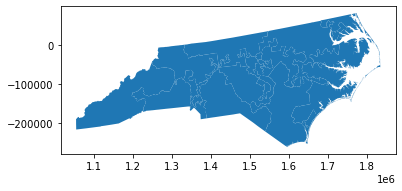

In [12]:
# Subset to North Carolina
nc_congress = congress[congress.STATEFP == "37"]
nc_congress.plot()

Now we pass these two sets of spatial data to `calculate_dislocation`. Note that `calculate_dislocation` will automatically convert the district shapefile to the projection of your representative voter points.

In [13]:
dislocation = pdn.calculate_dislocation(voters_w_knn, nc_congress, 
                                        knn_column='knn_shr_dem', 
                                        dem_column='dem')

In [14]:
dislocation.head()

,dem,knn_shr_dem,district_dem_share,partisan_dislocation,geometry
0,1,0.467143,0.446541,-0.020602,POINT (1484114.922 -456702.522)
1,0,0.461429,0.446541,-0.014888,POINT (1504928.375 -464379.525)
2,1,0.451429,0.446541,-0.004888,POINT (1517888.151 -468082.711)
3,1,0.465714,0.446541,-0.019173,POINT (1486955.744 -455428.245)
4,0,0.467143,0.446541,-0.020602,POINT (1485347.210 -454431.095)


/Users/Nick/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  This is separate from the ipykernel package so we can avoid doing imports until


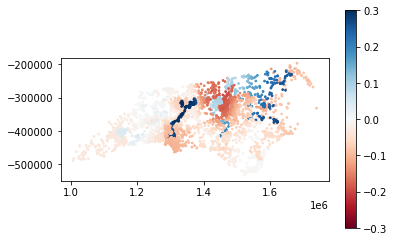

In [15]:
# Plot it!
from matplotlib import colors
dislocation_map = colors.DivergingNorm(vmin=-0.3, vcenter=0., vmax=0.2)
dislocation.plot('partisan_dislocation', markersize=3, 
                 cmap='RdBu', legend=True, 
                 vmin=-0.3, vmax=0.3)